In [195]:
%matplotlib inline

In [231]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp

from matplotlib import pyplot as plt
from helpers import (
    draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc, signed_normalized_laplacian, flatten,
    pos_adj, neg_adj
)
from viz_helpers import draw_query_result
from stat_helpers import avg_pos_deg, avg_neg_deg, cohe, oppo, agreement

In [223]:
def get_row_by_query(query):
    return df[df['query'] == query].iloc[0]

def show(q, **kwargs):
    r = get_row_by_query(q)
    fig, ax = draw_query_result(g, r['C1'], r['C2'], show_query=True, r=r, **kwargs)
    ax.set_title('q:{}, agr:{:.2f}, ham:{:.2f}, opp:{:.2f}, coh:{:.2f}, max_posdeg:{:.2f}'.format(
        q, r['agreement'], r['ham'], r['opp'], r['coh'], r['max_posdeg']
    ))

In [233]:
graph = 'slashdot'
g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
A = nx.adj_matrix(g, weight='sign')
df = pd.read_pickle('outputs/{}.pkl'.format(graph))

In [234]:
pos_A, neg_A = pos_adj(A), neg_adj(A)

# for weighted matrix, make it unweighted
if not (pos_A.data == 1).all():
    pos_A.data = np.ones(pos_A.data.shape, dtype='float64')
if not (neg_A.data == 1).all():
    neg_A.data = np.ones(neg_A.data.shape, dtype='float64')

In [235]:
df['size1'] = df['C1'].apply(lambda d: d.shape[0])
df['size2'] = df['C2'].apply(lambda d: d.shape[0])
df['balancedness'] = np.minimum(df['size1'], df['size2']) / (df['size1'] + df['size2'])

## filtering

exclude those that:

- C1 or C2 is small (<10 nodes)
- k != 200

In [236]:
df = df[df['k'] == 200]
df = df[(df['size1'] > 10) & (df['size2'] > 10)]

## data fields to add

- query degree
- avg pos/neg degree inside C1|C2
- opposition between C1 and C2

In [251]:
'qdeg' in df.columns

True

In [237]:
df['qdeg'] = df['query'].apply(lambda n: g.degree(n))

In [238]:
df['posdeg1'] = df['C1'].apply(lambda v: avg_pos_deg(pos_A, v))
df['posdeg2'] = df['C2'].apply(lambda v: avg_pos_deg(pos_A, v))
df['negdeg1'] = df['C1'].apply(lambda v: avg_pos_deg(neg_A, v))
df['negdeg2'] = df['C2'].apply(lambda v: avg_pos_deg(neg_A, v))

In [239]:
df['max_posdeg'] = np.maximum(df['posdeg1'], df['posdeg2'])

In [240]:
df['coh'] = df[['C1', 'C2']].apply(lambda d: cohe(pos_A, d['C1'], d['C2']), axis=1)
df['opp'] = df[['C1', 'C2']].apply(lambda d: oppo(neg_A, d['C1'], d['C2']), axis=1)
df['ham'] = 2 * df['coh'] * df['opp'] / (df['coh'] + df['opp'])

In [241]:
df['agreement'] = df[['C1', 'C2']].apply(lambda d: agreement(pos_A, neg_A, d['C1'], d['C2']), axis=1)

In [242]:
assert (df['coh'] >= 0).all()
assert (df['coh'] <= 1).all()
assert (df['opp'] >= 0).all()
assert (df['opp'] <= 1).all()
assert (df['ham'] >= 0).all()
assert (df['ham'] <= 1).all()
assert (df['agreement'] >= 0).all()
assert (df['agreement'] <= 1).all()


In [243]:
df[['size1', 'size2', 'posdeg1', 'posdeg2', 'negdeg1', 'negdeg2', 'opp', 'agreement']].head(3)

,size1,size2,posdeg1,posdeg2,negdeg1,negdeg2,opp,agreement
17,41,25,0.926829,1.680000,0.0,0.0,0.006829,1.0
25,32,17,1.250000,0.235294,0.0,0.0,0.005515,1.0
61,71,23,1.464789,0.782609,0.0,0.0,0.007961,1.0


In [244]:
fields_to_show = ['query', 'best_beta', 'size1', 'size2', 'agreement', 'ham', 'coh', 'opp', 'max_posdeg']

In [245]:
def show_top_k_by(by, k=3):
    print(df[fields_to_show].sort_values(by=by, ascending=False).head(k))    
    queries = df.sort_values(by=by, ascending=False).head(k)['query'].tolist()
    for q in queries:
        show(q)    
     
    # special treatment to "word" graph
    if graph == 'word':
        queries = df.sort_values(by='ham', ascending=False).head(3)['query'].tolist()
        for q in queries:
            r = get_row_by_query(q)
            print('q:', q)
            print('C1:', ', '.join([g.graph['i2w'][n] for n in r['C1']]))
            print('C2:', ', '.join([g.graph['i2w'][n] for n in r['C2']]))        
            print()        

## top-k by HAM

       query  best_beta  size1  size2  agreement       ham       coh  \
9904   46608   0.481203     23     11   0.621622  0.113663  0.180237   
9671   42131   0.534050     13     18   1.000000  0.107692  0.074786   
11915  46617   0.442379     26     14   0.765306  0.095285  0.133187   

            opp  max_posdeg  
9904   0.083004    3.130435  
9671   0.192308    1.888889  
11915  0.074176    2.538462  


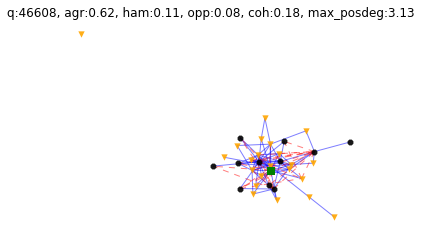

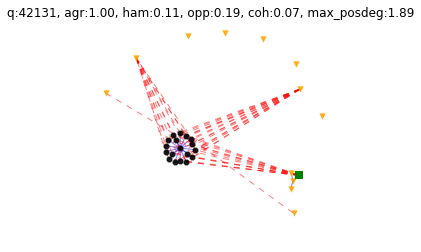

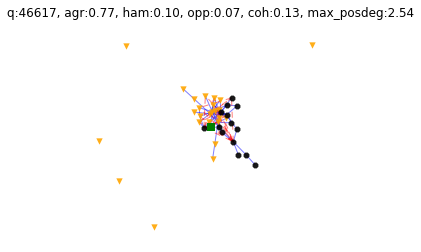

In [246]:
show_top_k_by('ham')

## top-k by agreement

      query  best_beta  size1  size2  agreement       ham       coh       opp  \
17    31731   0.667845     41     25        1.0  0.011912  0.046585  0.006829   
8227   8833   0.754717     89     40        1.0  0.003912  0.015098  0.002247   
7883   1213   0.807229     21     23        1.0  0.040129  0.056691  0.031056   

      max_posdeg  
17      1.680000  
8227    1.303371  
7883    1.714286  


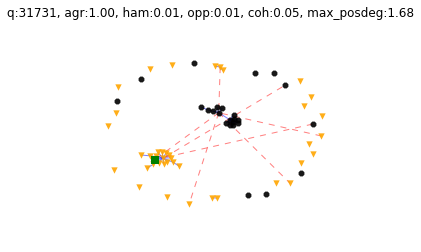

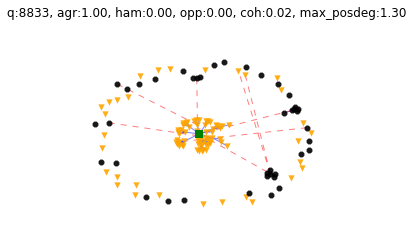

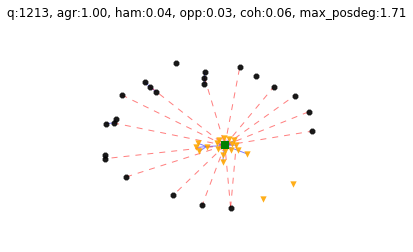

In [247]:
show_top_k_by('agreement')

## top-k by opposition

      query  best_beta  size1  size2  agreement       ham       coh       opp  \
9671  42131   0.534050     13     18        1.0  0.107692  0.074786  0.192308   
3061  38141   0.531915     27     13        1.0  0.072787  0.051282  0.125356   
5171   1301   0.808429     11     15        1.0  0.080513  0.068831  0.096970   

      max_posdeg  
9671    1.888889  
3061    1.333333  
5171    1.090909  


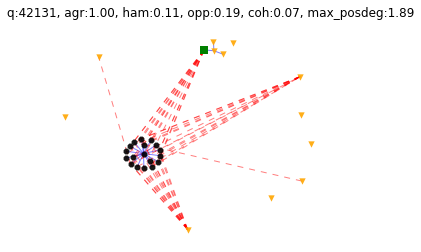

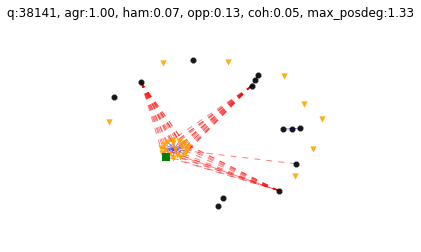

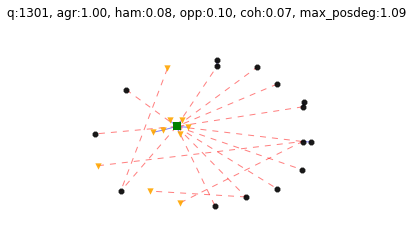

In [248]:
show_top_k_by('opp')

## top-k by coherence

       query  best_beta  size1  size2  agreement       ham       coh  \
9904   46608   0.481203     23     11   0.621622  0.113663  0.180237   
1765   57888   0.459954     41     26   1.000000  0.019234  0.141398   
11915  46617   0.442379     26     14   0.765306  0.095285  0.133187   

            opp  max_posdeg  
9904   0.083004    3.130435  
1765   0.010319    6.307692  
11915  0.074176    2.538462  


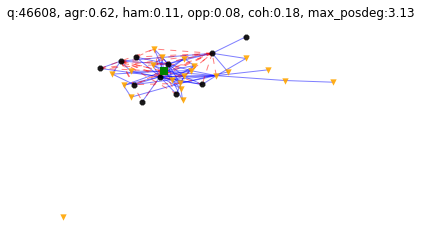

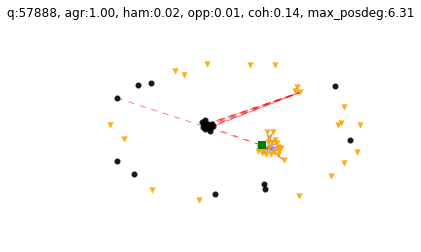

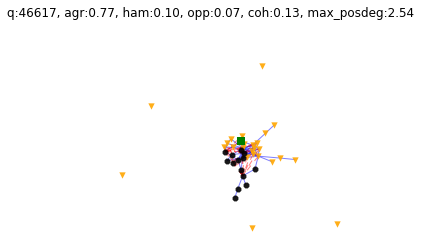

In [249]:
show_top_k_by('coh')

       query  best_beta  size1  size2  agreement       ham       coh  \
5338    1192   0.682195    107     90   0.971859  0.088421  0.070975   
11509  58599   0.709223     63    136   0.993789  0.075568  0.072507   
9426   19482   0.712544     48    152   0.985075  0.091296  0.077128   

            opp  max_posdeg  
5338   0.117238   15.046729  
11509  0.078898    8.984127  
9426   0.111842    7.250000  


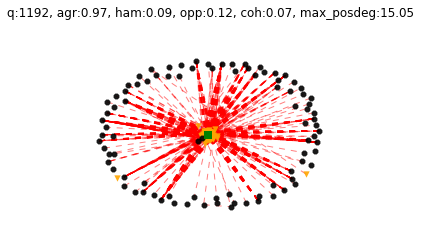

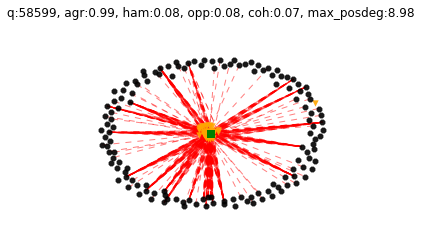

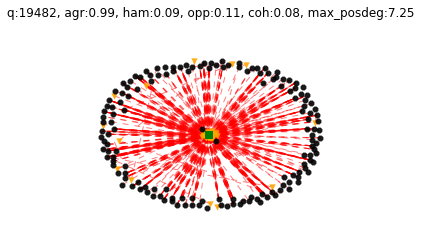

In [228]:
show_top_k_by('max_posdeg')